## RQ3. ForAI-agentpullrequests,howdosimplehuman–AIcollaborationpatterns(based onfollow-upcommits)relatetomergerateandtime-to-merge?

In [1]:
import pandas as pd
import numpy as np

### Step 1: Load base data for RQ3

In [2]:
pr = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
commit_details = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")
pr_review_comments = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_review_comments.parquet")

print("PR columns:\n", pr.columns)
print("\ncommit_details columns:\n", commit_details.columns)
print("\npr_review_comments columns:\n", pr_review_comments.columns)

PR columns:
 Index(['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state',
       'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url',
       'html_url'],
      dtype='object')

commit_details columns:
 Index(['sha', 'pr_id', 'author', 'committer', 'message', 'commit_stats_total',
       'commit_stats_additions', 'commit_stats_deletions', 'filename',
       'status', 'additions', 'deletions', 'changes', 'patch'],
      dtype='object')

pr_review_comments columns:
 Index(['id', 'pull_request_review_id', 'user', 'user_type', 'diff_hunk',
       'path', 'position', 'original_position', 'commit_id',
       'original_commit_id', 'body', 'pull_request_url', 'created_at',
       'updated_at', 'in_reply_to_id'],
      dtype='object')


### Step 2: Restrict to AI-generated PRs with a final outcome

In [3]:
# 2.1 Select AI PRs
# Here we assume PRs with a non-null `agent` are AI-generated.
ai_pr = pr[pr["agent"].notna()].copy()
print("Number of AI PRs:", len(ai_pr))

# 2.2 Build base PR-level table for RQ3
rq3 = ai_pr[["id", "state", "created_at", "merged_at", "html_url"]].rename(
    columns={"id": "pr_id"}
).copy()

# 2.3 Parse timestamps
rq3["created_at"] = pd.to_datetime(rq3["created_at"], errors="coerce")
rq3["merged_at"] = pd.to_datetime(rq3["merged_at"], errors="coerce")

# 2.4 Compute time-to-merge (in days)
rq3["time_to_merge_days"] = (
    (rq3["merged_at"] - rq3["created_at"]).dt.total_seconds() / (60 * 60 * 24)
)

# 2.5 Binary merged flag (for merge rate)
rq3["merged"] = rq3["merged_at"].notna().astype(float)

rq3.head()

Number of AI PRs: 33596


,pr_id,state,created_at,merged_at,html_url,time_to_merge_days,merged
0,3264933329,closed,2025-07-26 02:59:01+00:00,NaT,https://github.com/milvus-io/pymilvus/pull/2911,NaN,0.0
1,3265118634,closed,2025-07-26 04:56:55+00:00,2025-07-26 22:12:24+00:00,https://github.com/classmethod/tsumiki/pull/2,0.719086,1.0
2,3265640341,closed,2025-07-26 13:31:19+00:00,2025-07-26 13:37:22+00:00,https://github.com/steipete/Peekaboo/pull/30,0.004201,1.0
3,3265709660,closed,2025-07-26 14:07:22+00:00,2025-07-26 14:45:30+00:00,https://github.com/sugyan/claude-code-webui/pu...,0.026481,1.0
4,3265782173,open,2025-07-26 15:02:48+00:00,NaT,https://github.com/paradigmxyz/reth/pull/17625,NaN,0.0


### Step 3: Add review activity (number of review comments per PR)

In [4]:
# pr_review_comments links to PR via `pull_request_url`,
# which matches `pr["html_url"]`.
rev_counts = (
    pr_review_comments.groupby("pull_request_url")
    .size()
    .reset_index(name="n_review_comments")
)

rq3 = rq3.merge(
    rev_counts,
    left_on="html_url",
    right_on="pull_request_url",
    how="left",
)

# Missing values mean "no review comments"
rq3["n_review_comments"] = rq3["n_review_comments"].fillna(0).astype(int)

# Drop the URL column that came from the comments table
rq3 = rq3.drop(columns=["pull_request_url"])

rq3[["pr_id", "n_review_comments"]].head()

,pr_id,n_review_comments
0,3264933329,0
1,3265118634,0
2,3265640341,0
3,3265709660,0
4,3265782173,0


### Step 4: Detect human follow-up commits (with bot filtering)

In [5]:
# 4.1 Helper to decide whether a committer looks like a bot/system account
def is_bot(name: str) -> bool:
    """
    Return True if the committer name looks like a bot or GitHub system account.
    We treat names containing 'bot' or equal to some known bot labels as bots.
    """
    if pd.isna(name):
        return False
    s = str(name).lower().strip()
    if s.endswith("[bot]") or "bot" in s:
        return True
    if s in {"github", "github-actions", "dependabot"}:
        return True
    return False

In [6]:
# 4.2 Restrict commits to the AI PRs we are studying
ai_pr_ids = set(rq3["pr_id"])
cd_ai = commit_details[commit_details["pr_id"].isin(ai_pr_ids)].copy()

In [7]:
# 4.3 Mark bot committers
cd_ai["committer_is_bot"] = cd_ai["committer"].apply(is_bot)

In [8]:
# 4.4 Define "human follow-up commit"
# A commit is considered a human follow-up when:
#   - committer is NOT a bot / system account, AND
#   - author != committer (someone different from the original AI/author)

cd_ai["is_human_followup_commit"] = (
    (cd_ai["author"] != cd_ai["committer"]) & (~cd_ai["committer_is_bot"])
)

cd_ai[["pr_id", "author", "committer", "committer_is_bot", "is_human_followup_commit"]].head()

,pr_id,author,committer,committer_is_bot,is_human_followup_commit
0,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],True,False
1,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],True,False
2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],True,False
3,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],True,False
4,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],True,False


### Step 5: Aggregate human follow-up info to PR level & define patterns

In [9]:
# 5.1 Count human follow-up commits per PR
human_followup_per_pr = (
    cd_ai.groupby("pr_id")["is_human_followup_commit"]
    .sum()
    .reset_index(name="n_human_followup_commits")
)

In [10]:
# 5.2 Boolean: does this PR have at least one human follow-up commit?
human_followup_per_pr["has_human_followup"] = (
    human_followup_per_pr["n_human_followup_commits"] > 0
)

human_followup_per_pr.head()

,pr_id,n_human_followup_commits,has_human_followup
0,2756921963,0,False
1,2757103560,0,False
2,2757124156,0,False
3,2757125491,0,False
4,2757179026,0,False


In [11]:
# 5.3 Merge human follow-up info into the PR-level table

rq3 = rq3.merge(
    human_followup_per_pr[["pr_id", "n_human_followup_commits", "has_human_followup"]],
    on="pr_id",
    how="left",
)

# PRs without any row in commit_details → treat as no human follow-up
rq3["n_human_followup_commits"] = rq3["n_human_followup_commits"].fillna(0).astype(int)
rq3["has_human_followup"] = rq3["has_human_followup"].fillna(False)

/var/folders/y_/26zj9gjs1l38qhmx7wljcnnr0000gn/T/ipykernel_22336/1666605269.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rq3["has_human_followup"] = rq3["has_human_followup"].fillna(False)


In [12]:
# 5.4 Collaboration pattern:
#   - 'agent_only'        : AI commits only, no human follow-up
#   - 'agent_then_human'  : AI commits + at least one human follow-up commit
rq3["collab_pattern"] = np.where(
    rq3["has_human_followup"], "agent_then_human", "agent_only"
)

print("Counts by collaboration pattern:")
print(rq3["collab_pattern"].value_counts())

rq3.head()

Counts by collaboration pattern:
collab_pattern
agent_only          29887
agent_then_human     3709
Name: count, dtype: int64


,pr_id,state,created_at,merged_at,html_url,time_to_merge_days,merged,n_review_comments,n_human_followup_commits,has_human_followup,collab_pattern
0,3264933329,closed,2025-07-26 02:59:01+00:00,NaT,https://github.com/milvus-io/pymilvus/pull/2911,NaN,0.0,0,0,False,agent_only
1,3265118634,closed,2025-07-26 04:56:55+00:00,2025-07-26 22:12:24+00:00,https://github.com/classmethod/tsumiki/pull/2,0.719086,1.0,0,0,False,agent_only
2,3265640341,closed,2025-07-26 13:31:19+00:00,2025-07-26 13:37:22+00:00,https://github.com/steipete/Peekaboo/pull/30,0.004201,1.0,0,1,True,agent_then_human
3,3265709660,closed,2025-07-26 14:07:22+00:00,2025-07-26 14:45:30+00:00,https://github.com/sugyan/claude-code-webui/pu...,0.026481,1.0,0,0,False,agent_only
4,3265782173,open,2025-07-26 15:02:48+00:00,NaT,https://github.com/paradigmxyz/reth/pull/17625,NaN,0.0,0,0,False,agent_only


### Step 6: RQ3 summary statistics

In [13]:
rq3_summary = rq3.groupby("collab_pattern").agg(
    n_pr=("pr_id", "count"),
    merge_rate=("merged", "mean"),
    median_ttm=("time_to_merge_days", "median"),
    avg_review_comments=("n_review_comments", "mean"),
    avg_n_human_followup=("n_human_followup_commits", "mean"),
).reset_index()

# For easier interpretation, also keep merge rate in percentage
rq3_summary["merge_rate_pct"] = rq3_summary["merge_rate"] * 100

print("RQ3 summary by collaboration pattern:")
print(rq3_summary)

RQ3 summary by collaboration pattern:
     collab_pattern   n_pr  merge_rate  median_ttm  avg_review_comments  \
0        agent_only  29887    0.717168    0.001192                  0.0   
1  agent_then_human   3709    0.695605    0.586742                  0.0   

   avg_n_human_followup  merge_rate_pct  
0              0.000000       71.716800  
1             48.108115       69.560528  


### Step 7: Simple visualizations for RQ3

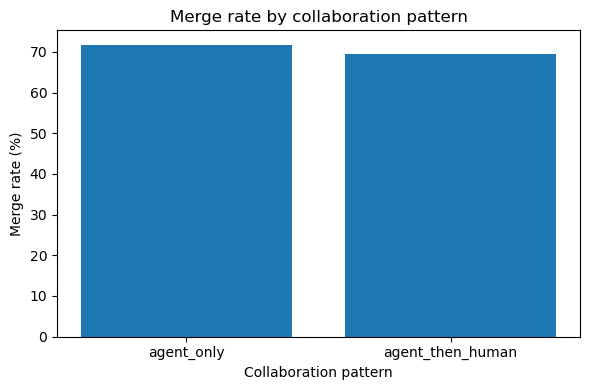

In [14]:
import matplotlib.pyplot as plt

# 7.1: Merge rate by collaboration pattern
plt.figure(figsize=(6, 4))
plt.bar(rq3_summary["collab_pattern"], rq3_summary["merge_rate_pct"])
plt.title("Merge rate by collaboration pattern")
plt.ylabel("Merge rate (%)")
plt.xlabel("Collaboration pattern")
plt.tight_layout()
plt.show()

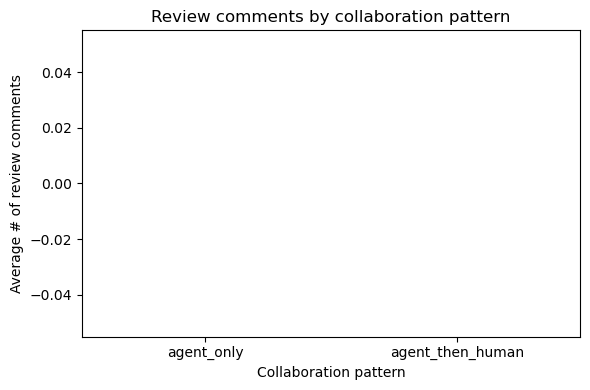

In [15]:
# 7.2: Average review comments by collaboration pattern
plt.figure(figsize=(6, 4))
plt.bar(rq3_summary["collab_pattern"], rq3_summary["avg_review_comments"])
plt.title("Review comments by collaboration pattern")
plt.ylabel("Average # of review comments")
plt.xlabel("Collaboration pattern")
plt.tight_layout()
plt.show()

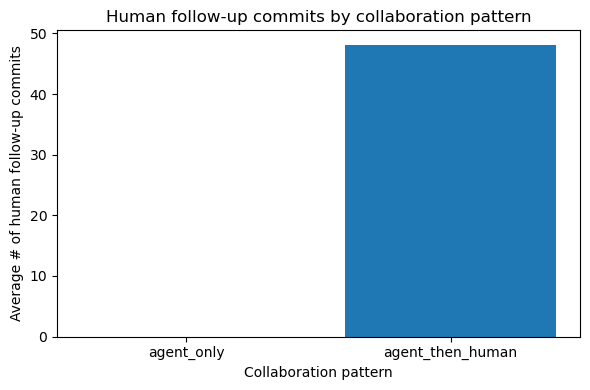

In [16]:
# 7.3: Average # of human follow-up commits (optional)
plt.figure(figsize=(6, 4))
plt.bar(rq3_summary["collab_pattern"], rq3_summary["avg_n_human_followup"])
plt.title("Human follow-up commits by collaboration pattern")
plt.ylabel("Average # of human follow-up commits")
plt.xlabel("Collaboration pattern")
plt.tight_layout()
plt.show()